In [81]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import os
from uncertainties import ufloat
from scipy.optimize import curve_fit

In [143]:
sizes = pd.read_csv('/Users/js/school/phy224/fluid/sizes.csv')
sizes['radius'] = sizes.diameter / 2

In [124]:
fluid = 'glycerine' #either 'water' or 'glycerine'. when you change this, change the model for the fit. 

maindir = f'/Users/js/school/phy224/fluid/drops/{fluid}'

Image below shows how the data is stored. For the actual .txt files, the file name doesn't matter as long as it is a .txt file. Here it's named so that the 1.txt, 2.txt, etc. are from the first session of data collection and the drop1.txt, drop2.txt, etc. are from the second session. The analysis doesn't distinguish between the sessions though.

<img src='filestructure.png'>

In [140]:
# colour function to make the plot look pretty
def get_colours(palette, n):
    clrs = []
    cmap = matplotlib.cm.get_cmap(palette, n)
    for i in range(cmap.N):
        rgb = cmap(i)[:3]
        clrs.append(matplotlib.colors.rgb2hex(rgb))
    return clrs

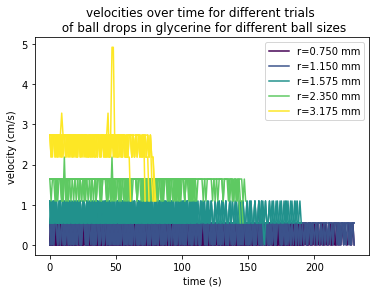

In [142]:
n = len(os.listdir(maindir))
cols = get_colours('viridis', n)
allmeans = [0] * n # mean velocities for each ball size
for size in sorted(os.listdir(maindir)): # loop over each size
    meanvels = [] # mean velocity over all trial drops for a ball of a given size
    for dropnum in os.listdir(f'{maindir}/{size}'): # loop over each trial
        if dropnum.endswith('.txt'):
            time, pos = np.loadtxt(f'{maindir}/{size}/{dropnum}', unpack=True, skiprows=2)
            time = np.array([ufloat(i, 0.0005) for i in time.tolist()]) # 0.0005 here suggested by Alex
            pos = np.array([ufloat(j, 0.002) for j in pos.tolist()])#  0.0002 here suggested by Alex
            condition = pos > 1e-6 # cutoff to remove parts of data where the ball is out of the camera frame. 
            time, pos = time[condition], pos[condition]
            vel = np.diff(pos) # get velocity from position
#             plt.plot([k.nominal_value for k in vel]) # this is the plot without the first few seconds cut off. 
            vel = vel[8:] # use this instead. cut off first few seconds of data. 
            plt.plot([k.nominal_value for k in vel], c=cols[int(size)-1])
            plt.xlabel('time (s)')
            plt.ylabel('velocity (cm/s)')
            plt.title(f'velocities over time for different trials \n of ball drops in {fluid} for different ball sizes')
            meanvels.append(vel.mean()) # mean velocity for a trial
    plt.plot([],[], c=cols[int(size)-1], label=f'r={sizes[sizes.fluid == fluid].radius.values[(int(size)-1)]:.3f} mm') # grouped labels
    plt.legend()
    meanvels = np.array(meanvels) 
    allmeans[int(size)-1] = meanvels.mean() # mean velocity for each size
plt.savefig(f'{fluid}.png')

In [127]:
# sanity check.
for j in allmeans:
    print(j)

0.198321+/-0.000006
0.430908+/-0.000006
0.735034+/-0.000009
1.548837+/-0.000009
2.572334+/-0.000016


In [128]:
# correction for the wall effect
def wallcorr(v, d, D):
    return v / (1 - 2.104*(d/D) + 2.089*(d/D)**2)

In [129]:
# corrected velocities
corrvels = [(wallcorr(v/100, d/1000, 0.095) * 100) for d, v in zip(sizes[sizes.fluid == fluid].diameter, allmeans)]
for j in corrvels:
    print(j)

0.205025+/-0.000006
0.453451+/-0.000006
0.788213+/-0.000009
1.718980+/-0.000010
2.961138+/-0.000018


In [130]:
def reynolds(rho, v, l, eta):
    return (rho * v * l) / eta

In [131]:
# calculating the reynolds number
dens = 1.26 if fluid == 'glycerine' else 1.
visc = 9.34 if fluid == 'glycerine' else 0.01

reys = [(reynolds(dens, v, d/10, visc)) for d, v in zip(sizes[sizes.fluid == fluid].diameter, corrvels)]
for r in reys:
    print(r)

0.00414880+/-0.00000013
0.01406959+/-0.00000018
0.0334948+/-0.0000004
0.1089915+/-0.0000006
0.2536624+/-0.0000015


In [132]:
# general power law to serve as reference
def model(x, a, b):
    return a * x**b

# eq. 18, use for glycerine
def model1(x, a):
    return a * x**2

# eq. 12, use for water
def model2(x, a):
    return a * x**0.5

In [133]:
popt, pcov = curve_fit(f=model, xdata=sizes[sizes.fluid == fluid].radius, ydata=[i.nominal_value for i in corrvels], sigma=[j.std_dev for j in corrvels], absolute_sigma=True)
popt2, pcov2 = curve_fit(f=model1, xdata=sizes[sizes.fluid == fluid].radius, ydata=[i.nominal_value for i in corrvels], sigma=[j.std_dev for j in corrvels], absolute_sigma=True)
print(popt)
print(popt2)

[0.34755792 1.85880075]
[0.30716645]


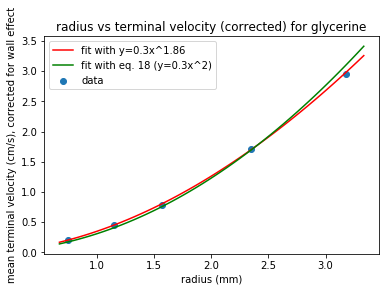

In [134]:
xdat = np.linspace(min(sizes[sizes.fluid == fluid].radius)*0.9, max(sizes[sizes.fluid == fluid].radius)*1.05)
plt.scatter(sizes[sizes.fluid == fluid].radius, [i.nominal_value for i in corrvels], label='data')
plt.plot(xdat, model(xdat, *popt), c='r', label=f'fit with y={popt[0]:.1f}x^{popt[1]:.2f}')
plt.plot(xdat, model1(xdat, *popt2), c='g', label=f'fit with eq. 18 (y={popt2[0]:.1f}x^2)')
plt.xlabel('radius (mm)')
plt.ylabel('mean terminal velocity (cm/s), corrected for wall effect')
plt.title(f'radius vs terminal velocity (corrected) for {fluid}')
plt.legend();


In [138]:
def rcs(pred, target, uncertainty, n_params):
    return np.square((pred - target) / uncertainty).sum() / (pred.size - n_params)

In [141]:
# very high reduced chi squared values because small uncertainties
rcs(model1(sizes[sizes.fluid == fluid].radius, *popt2), [i.nominal_value for i in corrvels], [j.std_dev for j in corrvels], 1)

40516559.18591635